# Watch Price Valuator

## Imports

In [114]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (12, 6)
plt.rc('axes', titlesize=22) 
plt.rc('figure', titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

## Data

### Extract

In [79]:
sqlite_file_name = "../scraper/database.db"
sqlite_url = f"sqlite:///{sqlite_file_name}"

In [80]:
df_original = pd.read_sql_table('watch', sqlite_url)

In [81]:
df = df_original.copy()

### Transform

In [82]:
df.columns

Index(['id', 'product_url', 'brand', 'series', 'model_num', 'model_id',
       'price', 'year', 'box', 'papers', 'image_url', 'image_filename'],
      dtype='object')

In [83]:
df.drop(['id', 'model_num', 'model_id', 'product_url', 'image_url', 'image_filename'], axis=1, inplace=True)

In [84]:
df.dtypes

brand     object
series    object
price      int64
year       int64
box         bool
papers      bool
dtype: object

In [85]:
df = df.astype({
    'brand': 'category',
    'series': 'category',
    # 'model_num': 'category'
})

In [86]:
df.shape

(4299, 6)

In [87]:
df.head()

,brand,series,price,year,box,papers
0,Rolex,Datejust,10500,2014,True,True
1,Omega,Speedmaster MKII,3560,2018,True,True
2,Cartier,Tank Francaise,2450,2007,True,False
3,Tag Heuer,Carrera,3470,2019,True,True
4,Rolex,Submariner,12100,2020,True,True


In [88]:
X, y = df.drop('price', axis=1), df['price']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)

### Inspect

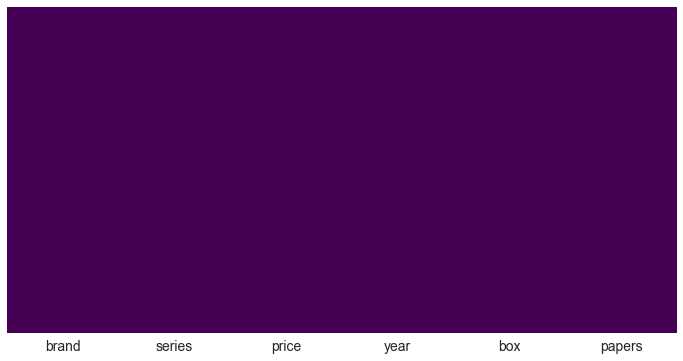

In [90]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

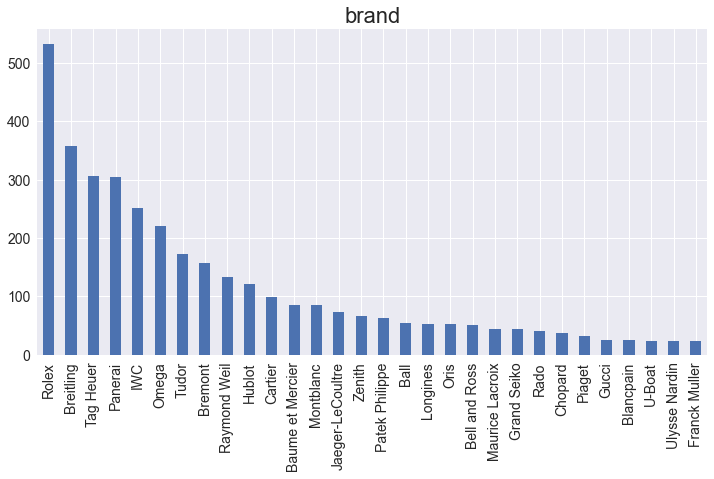

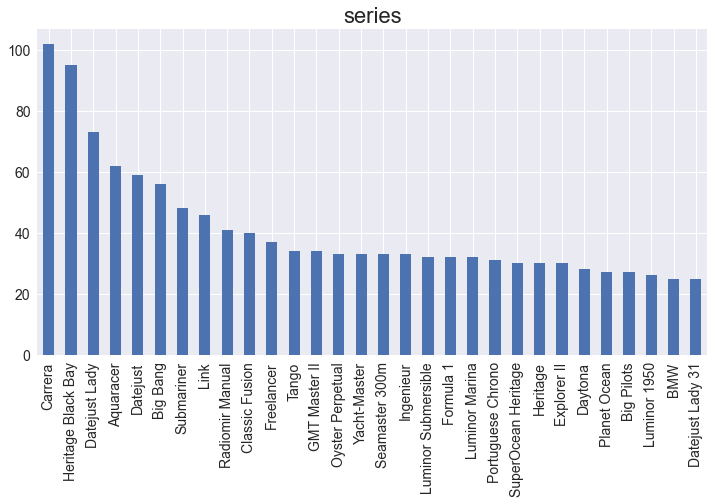

In [91]:
for col in ['brand', 'series']:#, 'model_num']:
    X_train[col].value_counts()[:30].plot(kind='bar')
    plt.title(col)
    plt.show()

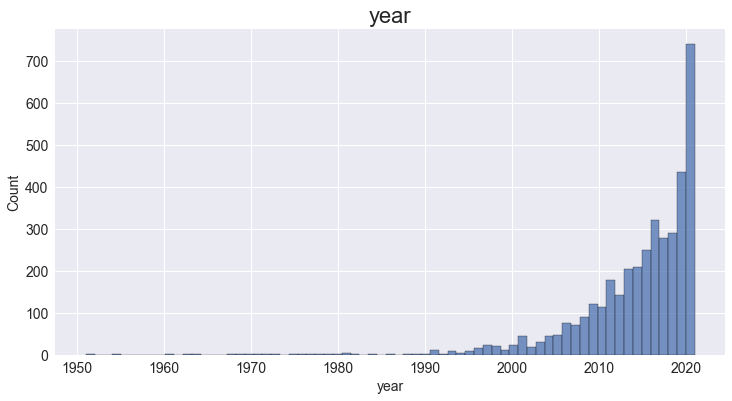

In [92]:
sns.histplot(data=X_train, x='year')
plt.title('year')
plt.show()

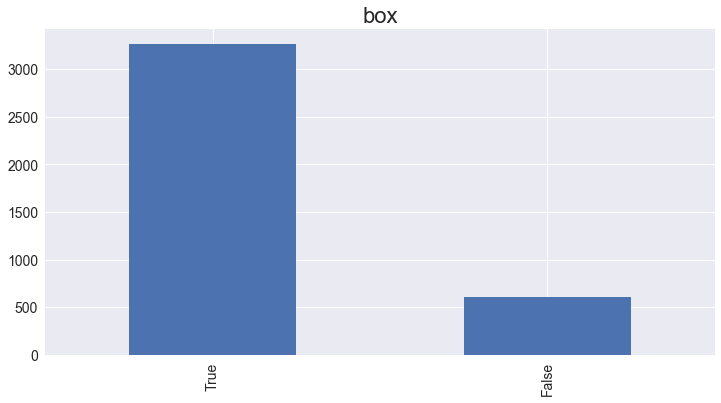

In [93]:
X_train['box'].value_counts().plot(kind='bar')
plt.title('box')
plt.show()

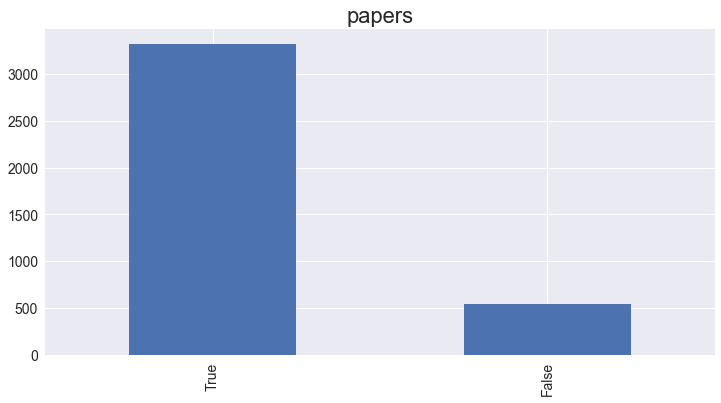

In [94]:
X_train['papers'].value_counts().plot(kind='bar')
plt.title('papers')
plt.show()

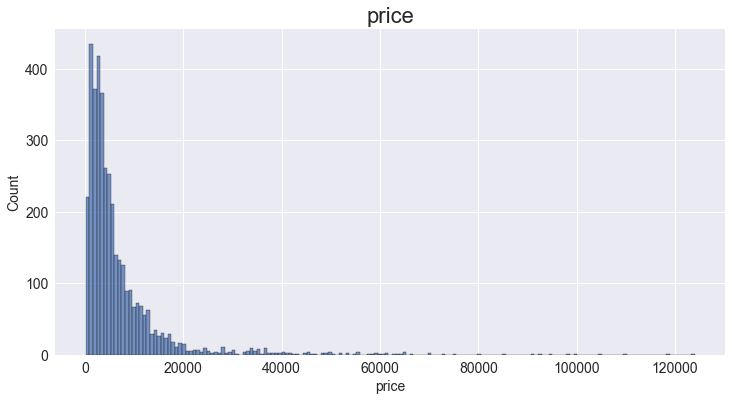

In [95]:
sns.histplot(y_train)
plt.title('price')
plt.show()

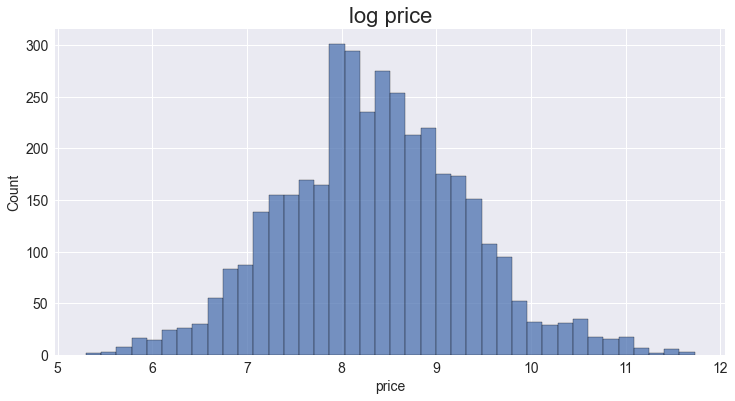

In [96]:
sns.histplot(np.log(y_train))
plt.title('log price')
plt.show()

### Feature Encoding

In [97]:
X_train_ = X_train.copy()
X_test_ = X_test.copy()

In [98]:
ohe_cols = ['brand', 'series']

In [99]:
ohe = OneHotEncoder()
ohe.fit(X[ohe_cols])

OneHotEncoder()

In [100]:
X_train_.reset_index(inplace=True)

In [101]:
X_train_ohe = pd.DataFrame(ohe.transform(X_train_[ohe_cols]).toarray(), columns=ohe.get_feature_names())

In [102]:
X_train_ = X_train_.drop(ohe_cols, axis=1).join(X_train_ohe)

In [103]:
X_train_['box'] = X_train_['box'].map({True: 1, False: 0})

In [104]:
X_train_['papers'] = X_train_['papers'].map({True: 1, False: 0})

In [105]:
X_test_.reset_index(inplace=True)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_[ohe_cols]).toarray(), columns=ohe.get_feature_names())
X_test_ = X_test_.drop(ohe_cols, axis=1).join(X_test_ohe)
X_test_['box'] = X_test_['box'].map({True: 1, False: 0})
X_test_['papers'] = X_test_['papers'].map({True: 1, False: 0})

In [125]:
-cross_val_score(LinearRegression(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

235321820451.261

In [126]:
-cross_val_score(Lasso(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

6030.172811134574

In [127]:
-cross_val_score(Ridge(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

5966.118547715936

In [128]:
-cross_val_score(DecisionTreeRegressor(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

7644.720511240051

In [130]:
-cross_val_score(RandomForestRegressor(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

6300.847081282534

In [131]:
-cross_val_score(XGBRegressor(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

6317.11692093768

In [132]:
-cross_val_score(LGBMRegressor(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

7448.201370574085

### Embeddings

In [133]:
X_train_ = X_train.copy()
X_test_ = X_test.copy()

In [134]:
X_train_['box'] = X_train_['box'].map({True: 1, False: 0})
X_train_['papers'] = X_train_['papers'].map({True: 1, False: 0})

In [135]:
def rm_spaces(feature):
    return re.sub(r'[^0-9a-zA-Z]', '', feature)

In [136]:
brand_tokenizer = Tokenizer(oov_token="<OOV>")
brand_tokenizer.fit_on_texts(X['brand'].apply(lambda x: rm_spaces(x)))
brand_tokenizer.word_index

{'<OOV>': 1,
 'rolex': 2,
 'breitling': 3,
 'tagheuer': 4,
 'panerai': 5,
 'iwc': 6,
 'omega': 7,
 'tudor': 8,
 'bremont': 9,
 'raymondweil': 10,
 'hublot': 11,
 'cartier': 12,
 'baumeetmercier': 13,
 'montblanc': 14,
 'jaegerlecoultre': 15,
 'zenith': 16,
 'patekphilippe': 17,
 'ball': 18,
 'bellandross': 19,
 'oris': 20,
 'longines': 21,
 'mauricelacroix': 22,
 'grandseiko': 23,
 'rado': 24,
 'chopard': 25,
 'piaget': 26,
 'gucci': 27,
 'blancpain': 28,
 'franckmuller': 29,
 'ulyssenardin': 30,
 'uboat': 31,
 'audemarspiguet': 32,
 'girardperregaux': 33,
 'bvlgari': 34,
 'vacheronconstantin': 35,
 'tissot': 36,
 'breguet': 37,
 'frederiqueconstant': 38,
 'glashutteoriginal': 39,
 'chanel': 40,
 'christiandior': 41,
 'porschedesign': 42,
 'hamilton': 43,
 'corum': 44,
 'ebel': 45,
 'nomosglashutte': 46,
 'rogerdubuis': 47,
 'eterna': 48,
 'graham': 49,
 'parmigiani': 50,
 'jeanrichard': 51,
 'alpina': 52,
 'twsteel': 53,
 'chronoswiss': 54,
 'alangeandsohne': 55,
 'hmoserandcie': 56,


In [137]:
series_tokenizer = Tokenizer(oov_token="<OOV>")
series_tokenizer.fit_on_texts(X['series'].apply(lambda x: rm_spaces(x)))
series_tokenizer.word_index

{'<OOV>': 1,
 'carrera': 2,
 'heritageblackbay': 3,
 'datejustlady': 4,
 'aquaracer': 5,
 'datejust': 6,
 'bigbang': 7,
 'submariner': 8,
 'link': 9,
 'radiomirmanual': 10,
 'classicfusion': 11,
 'oysterperpetual': 12,
 'freelancer': 13,
 'gmtmasterii': 14,
 'formula1': 15,
 'seamaster300m': 16,
 'yachtmaster': 17,
 'planetocean': 18,
 'tango': 19,
 'ingenieur': 20,
 'portuguesechrono': 21,
 'superoceanheritage': 22,
 'luminormarina': 23,
 'luminorsubmersible': 24,
 'heritage': 25,
 'explorerii': 26,
 'daytona': 27,
 'datejustlady31': 28,
 'bigpilots': 29,
 'luminor1950': 30,
 'bmw': 31,
 'skydweller': 32,
 'martinbaker': 33,
 'complications': 34,
 'clifton': 35,
 'timewalker': 36,
 'solo': 37,
 'boeing': 38,
 'alt1': 39,
 'speedmastermoonwatch': 40,
 'aerospace': 41,
 'supermarine': 42,
 'pilotschrono': 43,
 'deepsea': 44,
 'navitimerworld': 45,
 'explorer': 46,
 'datejustii': 47,
 'aquatimer': 48,
 'blackbay': 49,
 'classimaexecutives': 50,
 'heritagecollection': 51,
 'datejust41': 5

In [138]:
X_train.reset_index()

,index,brand,series,year,box,papers
0,3916,Tag Heuer,Carrera,2021,True,True
1,1041,IWC,Pilots Chrono Antoine de St Exupéry,2017,True,True
2,1322,Grand Seiko,Spring Drive,2016,True,True
3,2260,Tag Heuer,Carrera,2019,True,True
4,1769,Breitling,Avenger II Seawolf,2017,False,True
...,...,...,...,...,...,...
3864,3444,Piaget,Possession,2015,True,True
3865,466,Breitling,Aerospace,2010,True,True
3866,3092,Montblanc,Heritage,2021,True,True
3867,3772,Bell and Ross,BR V3-94,2019,True,True


In [139]:
brand_train_labels = brand_tokenizer.texts_to_sequences(X_train['brand'].apply(lambda x: rm_spaces(x)))
brand_test_labels = brand_tokenizer.texts_to_sequences(X_test['brand'].apply(lambda x: rm_spaces(x)))

series_train_labels = series_tokenizer.texts_to_sequences(X_train['series'].apply(lambda x: rm_spaces(x)))
series_test_labels = series_tokenizer.texts_to_sequences(X_test['series'].apply(lambda x: rm_spaces(x)))

In [140]:
brand_train_labels = tf.squeeze(tf.constant(brand_train_labels))
brand_test_labels = tf.squeeze(tf.constant(brand_test_labels))

series_train_labels = tf.squeeze(tf.constant(series_train_labels))
series_test_labels = tf.squeeze(tf.constant(series_test_labels))

In [141]:
num_brand = len(brand_tokenizer.word_index)
num_series = len(series_tokenizer.word_index)

In [142]:
num_brand

78

In [143]:
num_series

772

In [144]:
num_brand**0.25

2.9718278662008415

In [145]:
num_series**0.25

5.271137256693247

In [146]:
early_stopping = EarlyStopping(patience=30, restore_best_weights=True)

In [147]:
brand_dim = 5
series_dim = 15


## Create the layers
# First input
input_brand = tf.keras.layers.Input(shape=(1,))
# Second input
input_series = tf.keras.layers.Input(shape=(1,))
# First embedding layer
embedding_brand = Embedding(input_dim=num_brand+1, output_dim=brand_dim,
                           name='embedding_brand')(input_brand)
# Second embedding layer
embedding_series = Embedding(input_dim=num_series+1, output_dim=series_dim,
                            name='embedding_series')(input_series)
# Concatenate the output of both embedding layers
concat = tf.keras.layers.Concatenate()([embedding_brand, embedding_series])

#
# concat = tf.keras.layers.Dense(12)(concat)

# A single neuron out with no activation function as this is a regression problem
output = tf.keras.layers.Dense(1)(concat)

# Create the model and feed it the layers to expect as inputs and outputs
model = tf.keras.Model(inputs=[input_brand, input_series],
                       outputs=output)
# Compile the model, with MSE as a loss function and Adam for the optimizer
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(lr=3e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
# Fit the model!
history = model.fit((brand_train_labels, series_train_labels), y_train.to_numpy(),
                    validation_data=((brand_test_labels, series_test_labels),
                                     y_test.to_numpy()), epochs=3000, callbacks=[early_stopping], verbose=2)
# List of performance histories
# histories.append(history)

Epoch 1/3000
121/121 - 2s - loss: 146006992.0000 - root_mean_squared_error: 12083.3350 - val_loss: 149353712.0000 - val_root_mean_squared_error: 12221.0352
Epoch 2/3000
121/121 - 0s - loss: 146005136.0000 - root_mean_squared_error: 12083.2588 - val_loss: 149351568.0000 - val_root_mean_squared_error: 12220.9482
Epoch 3/3000
121/121 - 0s - loss: 146002720.0000 - root_mean_squared_error: 12083.1582 - val_loss: 149348736.0000 - val_root_mean_squared_error: 12220.8320
Epoch 4/3000
121/121 - 0s - loss: 145999664.0000 - root_mean_squared_error: 12083.0322 - val_loss: 149345184.0000 - val_root_mean_squared_error: 12220.6865
Epoch 5/3000
121/121 - 0s - loss: 145995840.0000 - root_mean_squared_error: 12082.8740 - val_loss: 149340992.0000 - val_root_mean_squared_error: 12220.5156
Epoch 6/3000
121/121 - 0s - loss: 145991344.0000 - root_mean_squared_error: 12082.6875 - val_loss: 149336160.0000 - val_root_mean_squared_error: 12220.3174
Epoch 7/3000
121/121 - 0s - loss: 145986304.0000 - root_mean_squ

In [148]:
# Save the model after that hard work
model.save('trained_embedding_model.h5')

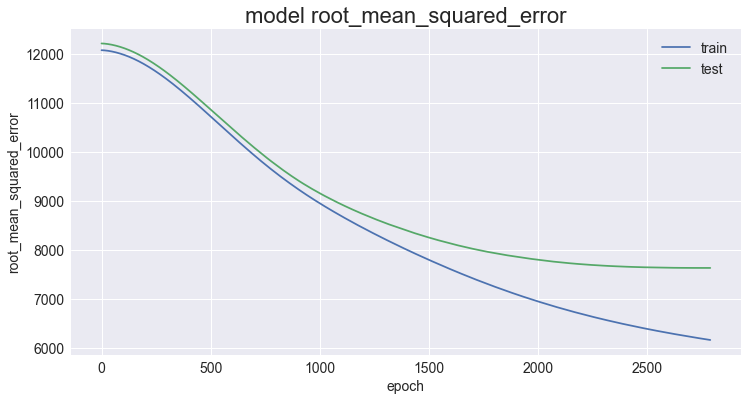

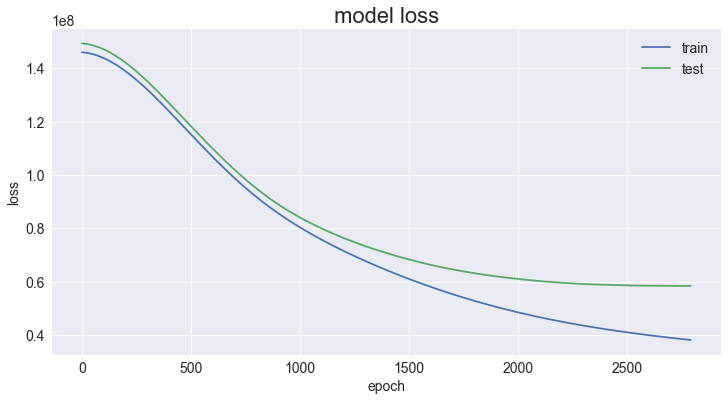

In [149]:
# summarize history for accuracy
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [150]:
# Grab each embedding layer from the previous model
embedding_layer_brand = model.get_layer('embedding_brand')
# Ensure that the layer's parameters cannot be changed anymore!
embedding_layer_brand.trainable = False

embedding_layer_series = model.get_layer('embedding_series')
embedding_layer_series.trainable = False

In [151]:
# Create 2 new 'models', which recieve the sequences and matrix multiplies with
# the embedding layers to generate n and m features per sample,
# for brand and series respectively

# Sequential model
feature_generator_brand = tf.keras.models.Sequential([
    # Input layer to establish the array shape to expect. This layer is also not trainable
    tf.keras.layers.InputLayer(input_shape=[1,]),
    # The learned embedding layer!
    embedding_layer_brand
])
# Same for second model
feature_generator_series = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1,]),
    embedding_layer_series
])

In [152]:
# Use the model's fit method to create the new features
brand_array = feature_generator_brand.predict(brand_train_labels)
print(brand_array.shape)
# Remove inner dimension, to go from 3D to 2D
brand_array = np.squeeze(brand_array, axis=1)
print(brand_array.shape)

(3869, 1, 5)
(3869, 5)


In [153]:
# Use the model's fit method to create the new features
series_array = feature_generator_series.predict(series_train_labels)
print(series_array.shape)
# Remove inner dimension, to go from 3D to 2D
series_array = np.squeeze(series_array, axis=1)
print(series_array.shape)

(3869, 1, 15)
(3869, 15)


In [154]:
features_array = np.concatenate((brand_array, series_array), axis=1)

In [155]:
embedding_cols = ["brand_embedding_" + str(i+1) for i in range(brand_dim)] + ["series_embedding_" + str(i+1) for i in range(series_dim)]

In [156]:
embedding_df = pd.DataFrame(features_array, columns=embedding_cols)

In [157]:
brand_train_labels = brand_tokenizer.texts_to_sequences(X['brand'].apply(lambda x: rm_spaces(x)))

In [158]:
def engineer_features(X: pd.DataFrame) -> pd.DataFrame:
    X_copy = X.copy()
    X_copy['box'] = X_copy['box'].map({True: 1, False: 0})
    X_copy['papers'] = X_copy['papers'].map({True: 1, False: 0})

    brand_labels = brand_tokenizer.texts_to_sequences(X['brand'].apply(lambda x: rm_spaces(x)))
    brand_labels = tf.squeeze(tf.constant(brand_labels))
    series_labels = series_tokenizer.texts_to_sequences(X['series'].apply(lambda x: rm_spaces(x)))
    series_labels = tf.squeeze(tf.constant(series_labels))

    brand_array = feature_generator_brand.predict(brand_labels)
    brand_array = np.squeeze(brand_array, axis=1)
    series_array = feature_generator_series.predict(series_labels)
    series_array = np.squeeze(series_array, axis=1)
    features_array = np.concatenate((brand_array, series_array), axis=1)

    embedding_cols = ["brand_embedding_" + str(i+1) for i in range(brand_dim)] + ["series_embedding_" + str(i+1) for i in range(series_dim)]
    embedding_df = pd.DataFrame(features_array, columns=embedding_cols)

    X_copy = X_copy.join(embedding_df)
    X_copy.drop(['brand', 'series'], axis=1, inplace=True)

    return X_copy

In [159]:
engineer_features(X)

,year,box,papers,brand_embedding_1,brand_embedding_2,brand_embedding_3,brand_embedding_4,brand_embedding_5,series_embedding_1,series_embedding_2,...,series_embedding_6,series_embedding_7,series_embedding_8,series_embedding_9,series_embedding_10,series_embedding_11,series_embedding_12,series_embedding_13,series_embedding_14,series_embedding_15
0,2014,1,1,-34.947243,-34.773460,-34.695969,-34.744896,34.837574,-1.399759,-1.332033,...,1.469140,-1.352210,-1.352244,1.247861,-1.387103,-1.375635,-1.281870,1.410484,1.294733,1.416806
1,2018,1,1,-11.923534,-11.836442,-11.787787,-11.747961,11.940881,-0.343460,-0.273865,...,0.379788,-0.311443,-0.305483,0.237527,-0.299812,-0.270942,-0.260538,0.338849,0.311238,0.331135
2,2007,1,0,-16.525291,-16.356298,-16.300386,-16.426828,16.431950,-2.412478,-2.348200,...,2.400083,-2.383051,-2.358951,2.340865,-2.387164,-2.381800,-2.310201,2.411355,2.394634,2.461173
3,2019,1,1,-2.611281,-2.502736,-2.407214,-2.491975,2.560030,2.156752,2.223192,...,-2.196563,2.201945,2.144671,-2.364342,2.228602,2.242712,2.281221,-2.177365,-2.244295,-2.154011
4,2020,1,1,-34.947243,-34.773460,-34.695969,-34.744896,34.837574,7.651656,7.664120,...,-7.658664,7.681897,7.670321,-7.737687,7.659101,7.673463,7.722296,-7.593254,-7.718606,-7.640550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4294,2016,1,1,-21.195124,-21.080921,-20.940781,-21.055822,21.111776,8.302163,8.353263,...,-8.328153,8.287858,8.269316,-8.439253,8.328358,8.298301,8.400936,-8.290228,-8.351475,-8.287973
4295,2019,1,1,-21.195124,-21.080921,-20.940781,-21.055822,21.111776,8.971148,9.006160,...,-8.924527,8.940971,9.010834,-9.035813,8.977036,8.952257,9.005942,-8.936442,-9.020571,-8.961500
4296,2010,1,1,-21.195124,-21.080921,-20.940781,-21.055822,21.111776,3.128435,3.063698,...,-3.119207,3.107945,3.139475,-3.170054,3.087703,3.116176,3.121797,-3.104128,-3.115379,-3.059880
4297,2015,1,1,-2.611281,-2.502736,-2.407214,-2.491975,2.560030,2.156752,2.223192,...,-2.196563,2.201945,2.144671,-2.364342,2.228602,2.242712,2.281221,-2.177365,-2.244295,-2.154011


In [160]:
X_train__, X_test__, y_train, y_test = train_test_split(
    engineer_features(X), y, test_size=0.10, random_state=42)

In [161]:
X_train__

,year,box,papers,brand_embedding_1,brand_embedding_2,brand_embedding_3,brand_embedding_4,brand_embedding_5,series_embedding_1,series_embedding_2,...,series_embedding_6,series_embedding_7,series_embedding_8,series_embedding_9,series_embedding_10,series_embedding_11,series_embedding_12,series_embedding_13,series_embedding_14,series_embedding_15
3916,2021,1,1,-2.611281,-2.502736,-2.407214,-2.491975,2.560030,2.156752,2.223192,...,-2.196563,2.201945,2.144671,-2.364342,2.228602,2.242712,2.281221,-2.177365,-2.244295,-2.154011
1041,2017,1,1,-21.195124,-21.080921,-20.940781,-21.055822,21.111776,-2.630139,-2.647247,...,2.584691,-2.566479,-2.613911,2.597251,-2.575870,-2.613095,-2.546497,2.655170,2.639721,2.605572
1322,2016,1,1,-8.174179,-8.050100,-8.055004,-8.120988,8.167208,4.434061,4.449234,...,-4.434814,4.367181,4.433973,-4.489671,4.365779,4.399129,4.428038,-4.372801,-4.439889,-4.453205
2260,2019,1,1,-2.611281,-2.502736,-2.407214,-2.491975,2.560030,2.156752,2.223192,...,-2.196563,2.201945,2.144671,-2.364342,2.228602,2.242712,2.281221,-2.177365,-2.244295,-2.154011
1769,2017,0,1,-7.675799,-7.474596,-7.423183,-7.489536,7.672227,-0.030507,0.036659,...,0.003289,0.002645,-0.011314,0.001477,0.002963,-0.003962,0.079674,0.017855,0.005959,-0.024213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,2015,1,1,-20.553253,-20.465796,-20.473228,-20.420774,20.490887,-1.391825,-1.398707,...,1.452248,-1.450068,-1.411083,1.350184,-1.435001,-1.446633,-1.408309,1.464502,1.383179,1.407400
466,2010,1,1,-7.675799,-7.474596,-7.423183,-7.489536,7.672227,-0.437687,-0.379328,...,0.380191,-0.354718,-0.392670,0.360469,-0.376373,-0.413808,-0.293395,0.455275,0.395623,0.381438
3092,2021,1,1,-8.572459,-8.466728,-8.415794,-8.414194,8.554809,2.919354,2.882622,...,-2.847884,2.882821,2.887767,-2.962512,2.903618,2.916685,2.966560,-2.933338,-2.896284,-2.894975
3772,2019,1,1,-8.960110,-8.820395,-8.833688,-8.822623,8.944522,0.010732,-0.007646,...,-0.038382,-0.020481,0.044041,-0.019707,0.045637,0.049684,0.058393,-0.044518,-0.039005,0.008439


In [162]:
-cross_val_score(LinearRegression(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

6027.602581319825

In [165]:
-cross_val_score(Lasso(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

C:\Users\JustinGodden\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49020372229.82134, tolerance: 29770057.36751535
  model = cd_fast.enet_coordinate_descent(
C:\Users\JustinGodden\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56562573980.56929, tolerance: 31357637.885231018
  model = cd_fast.enet_coordinate_descent(
C:\Users\JustinGodden\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43830804790.56155, tolerance: 27629856.123672053
  model = cd_fast.enet_coordinate_descent(
C:\Users\JustinGodden\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

6042.385902404666

In [166]:
-cross_val_score(Ridge(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

6022.873805595234

In [167]:
-cross_val_score(DecisionTreeRegressor(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

7095.586903662707

In [168]:
-cross_val_score(RandomForestRegressor(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

6039.841252341087

In [169]:
-cross_val_score(XGBRegressor(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

6520.501424672153

In [178]:
-cross_val_score(LGBMRegressor(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

5846.241544845105